In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_csv('NIFTY_50.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,P/E,P/B,Div Yield %
Date,,,,,,,
2000-01-03,1482.15,1592.90,1482.15,1592.2,25.91,4.63,0.95
2000-01-04,1594.40,1641.95,1594.40,1638.7,26.67,4.76,0.92
2000-01-05,1634.55,1635.50,1555.05,1595.8,25.97,4.64,0.95
2000-01-06,1595.80,1639.00,1595.80,1617.6,26.32,4.70,0.94
2000-01-07,1616.60,1628.25,1597.20,1613.3,26.25,4.69,0.94


 Random Forest Regressor

In [35]:
# Use previous day's data to predict today's close
X = df[['Open', 'High', 'Low', 'Close']].shift(1).dropna()
y = df['Close'][1:]

In [36]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [37]:
# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [38]:
# Evaluation
print("Random Forest Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")

Random Forest Evaluation:
MAE: 3685.3222
MSE: 22202226.5646
RMSE: 4711.9239
R² Score: -1.0744


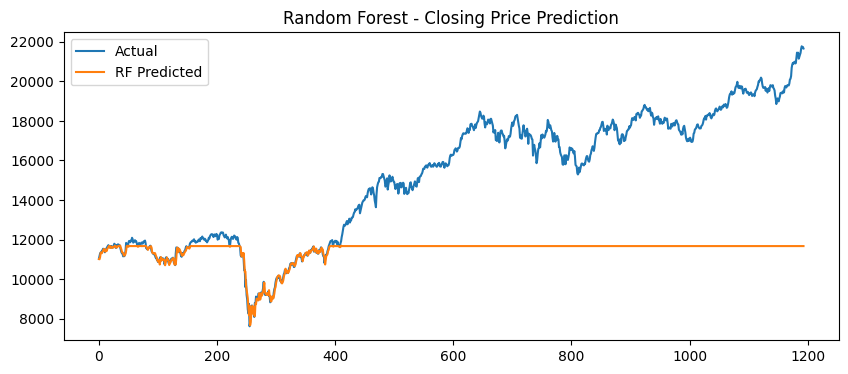

In [39]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='RF Predicted')
plt.title("Random Forest - Closing Price Prediction")
plt.legend()
plt.show()

BiLSTM (Bidirectional LSTM)

In [40]:
# Normalize data
close_data = df[['Close']].values
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_data)

In [41]:
# Create sequence data
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_bilstm, y_bilstm = create_dataset(scaled_close)
X_train_bilstm, X_test_bilstm = X_bilstm[:int(len(X_bilstm)*0.8)], X_bilstm[int(len(X_bilstm)*0.8):]
y_train_bilstm, y_test_bilstm = y_bilstm[:int(len(y_bilstm)*0.8)], y_bilstm[int(len(y_bilstm)*0.8):]

In [42]:
# Reshape for LSTM
X_train_bilstm = X_train_bilstm.reshape((X_train_bilstm.shape[0], X_train_bilstm.shape[1], 1))
X_test_bilstm = X_test_bilstm.reshape((X_test_bilstm.shape[0], X_test_bilstm.shape[1], 1))

In [43]:
# Build BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_bilstm.shape[1], 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# Train model
model.fit(X_train_bilstm, y_train_bilstm, epochs=10, batch_size=32, verbose=0)

In [45]:
# Predict and inverse scale
predicted_bilstm = model.predict(X_test_bilstm)
predicted_prices = scaler.inverse_transform(predicted_bilstm)
actual_prices = scaler.inverse_transform(y_test_bilstm)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [46]:
# Evaluation
print("🔁 BiLSTM Evaluation:")
print(f"MAE: {mean_absolute_error(actual_prices, predicted_prices):.4f}")
print(f"MSE: {mean_squared_error(actual_prices, predicted_prices):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(actual_prices, predicted_prices)):.4f}")
print(f"R² Score: {r2_score(actual_prices, predicted_prices):.4f}")


🔁 BiLSTM Evaluation:
MAE: 269.1509
MSE: 121051.8649
RMSE: 347.9251
R² Score: 0.9887


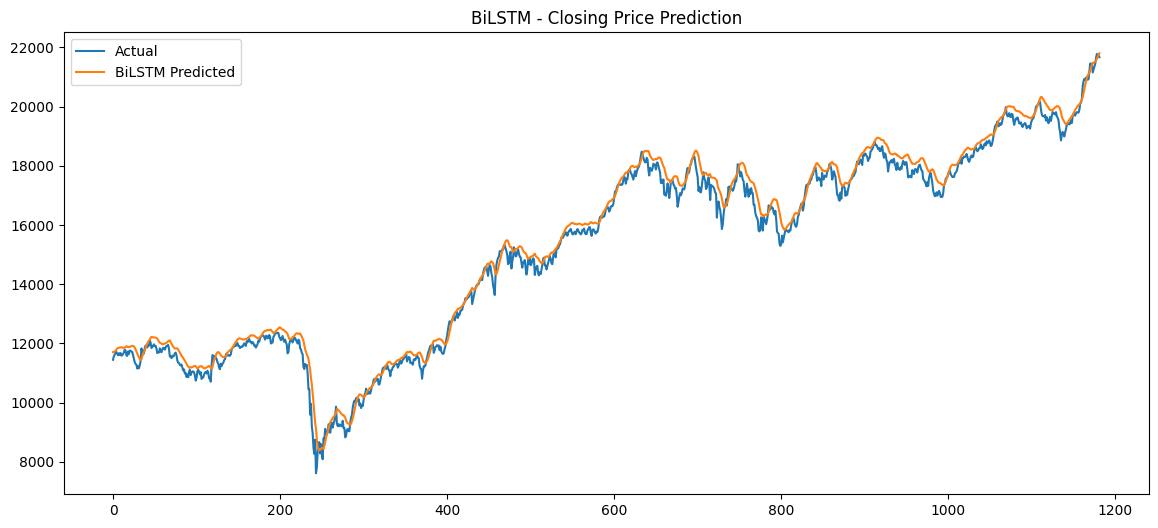

In [47]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='BiLSTM Predicted')
plt.title("BiLSTM - Closing Price Prediction")
plt.legend()
plt.show()

 BiLSTM Future Forecasting (7 Days Ahead)

In [48]:
# ⏳ Parameters
future_days = 7     # Predict next 7 days
time_steps = 60     # Use past 60 days

In [49]:
# Create sequence data for multi-step output
def create_dataset_future(data, time_steps, future_days):
    X, y = [], []
    for i in range(len(data) - time_steps - future_days):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps:i+time_steps+future_days].flatten())
    return np.array(X), np.array(y)

X_future, y_future = create_dataset_future(scaled_close, time_steps, future_days)


In [50]:
# Train-test split
X_train_f, X_test_f = X_future[:int(0.8*len(X_future))], X_future[int(0.8*len(X_future)):]
y_train_f, y_test_f = y_future[:int(0.8*len(y_future))], y_future[int(0.8*len(y_future)):]

In [51]:
# Model Input Reshaping
X_train_f = X_train_f.reshape((X_train_f.shape[0], X_train_f.shape[1], 1))
X_test_f = X_test_f.reshape((X_test_f.shape[0], X_test_f.shape[1], 1))

In [52]:
# Define BiLSTM Model for Future Forecasting
model_future = Sequential()
model_future.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(time_steps, 1)))
model_future.add(Bidirectional(LSTM(64)))
model_future.add(Dense(future_days))
model_future.compile(optimizer='adam', loss='mse')

In [53]:
#Train the model
model_future.fit(X_train_f, y_train_f, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0076
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3502e-04
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.1502e-04
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.0152e-04
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.6872e-05
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.1086e-05
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.0498e-05
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 7.2584e-05
Epoch 9/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 8.7242e-05
Epoch 10/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 7.1504e-05


In [54]:
# Predict
y_pred_future = model_future.predict(X_test_f)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [55]:
# Inverse scaling
y_pred_future_unscaled = scaler.inverse_transform(y_pred_future)
y_test_future_unscaled = scaler.inverse_transform(y_test_f)

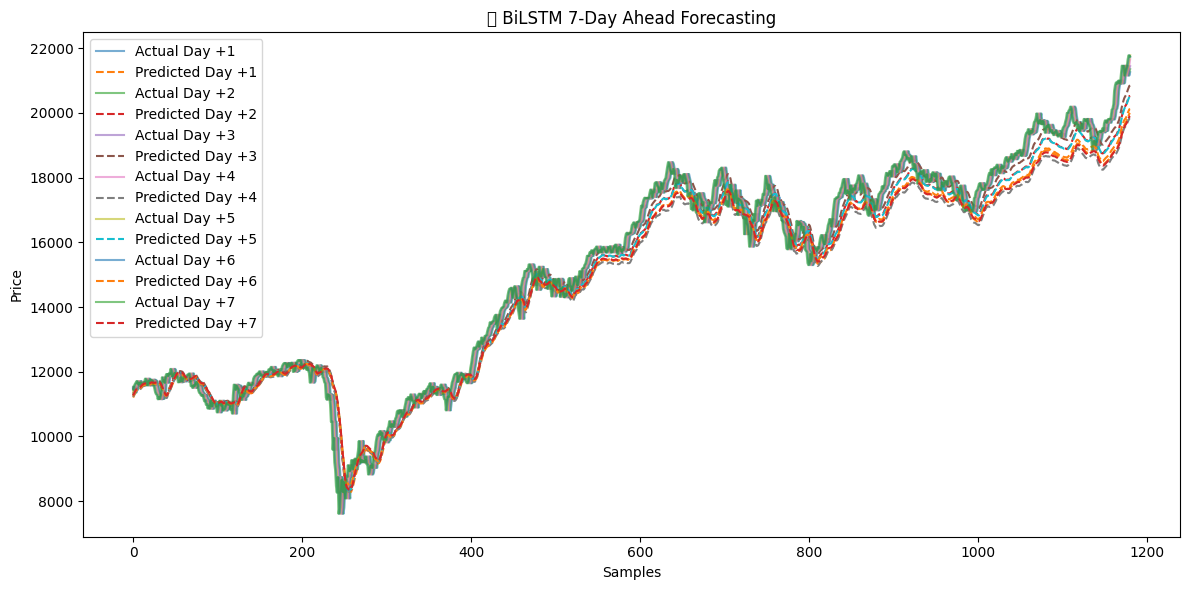

In [56]:
# Plot predictions for each day ahead
plt.figure(figsize=(12, 6))
for i in range(future_days):
    plt.plot(y_test_future_unscaled[:, i], label=f'Actual Day +{i+1}', alpha=0.6)
    plt.plot(y_pred_future_unscaled[:, i], linestyle='--', label=f'Predicted Day +{i+1}')
plt.title(f"📈 BiLSTM {future_days}-Day Ahead Forecasting")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# Metrics (optional for Day +1 only or avg)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("📌 Evaluation on Day +1 Forecast:")
print("MAE:", mean_absolute_error(y_test_future_unscaled[:, 0], y_pred_future_unscaled[:, 0]))
print("RMSE:", np.sqrt(mean_squared_error(y_test_future_unscaled[:, 0], y_pred_future_unscaled[:, 0])))
print("R²:", r2_score(y_test_future_unscaled[:, 0], y_pred_future_unscaled[:, 0]))

📌 Evaluation on Day +1 Forecast:
MAE: 443.6410783036091
RMSE: 552.9398171720859
R²: 0.9708645485924862
